# Importing libraries

In [1]:
import psycopg2
from psycopg2.extras import RealDictCursor
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import pandas as pd
import json
import numpy as np
import time
import pdb
from datetime import datetime
from shapely import wkb
from shapely.geometry import Point
import matplotlib.pyplot as plt
from methods import *
from scipy.optimize import minimize
from stations import *
import googlemaps 
import seaborn as sns
from tqdm import tqdm_notebook
from pandas.plotting import register_matplotlib_converters
from matplotlib.dates import DateFormatter
from scipy.stats import gamma, nbinom
from scipy.stats import truncnorm
from scipy.stats import norm
import statsmodels.api as sm
from tqdm import tqdm_notebook
sns.set_style('whitegrid')




# Querying

In [92]:
#Generating the dataframe from NFORS
fc_id = '93345'

#Querying elastic search for the results
es = Elasticsearch()
s = Search(using=es,index='*-fire-incident-*')
response = s.source(['description.event_opened',
                    'description.day_of_week']).query('match',fire_department__firecares_id=fc_id)
results_df = pd.DataFrame((d.to_dict() for d in response.scan()))
json_struct = json.loads(results_df.to_json(orient="records"))
df_flat = pd.io.json.json_normalize(json_struct)

df  = df_flat.copy()

KeyboardInterrupt: 

# Alternatively, you can just load the saved dataframe instead


In [93]:
df = pd.read_csv('query_results')

# Processing dataframe

In [37]:
#Extracting the date from the timestamp (i.e. '11/01/2012')
df['date'] = df['description.event_opened'].apply(lambda x: x[:10])
#Extracting minute
df['minute'] = df['description.event_opened'].apply(lambda x: x[11:16]) 
#Also want to map the minute to a continuous variable. i.e. 4:01 AM becomes 241
df['cont_minute'] = df['minute'].apply(lambda x: int(x[:2])*60+int(x[3:]))
df['hour'] = df['minute'].apply(lambda x: x[0:2])

#Then we do a groupby date and generate an expanded dataframe in which there is a row for every minute of every date
#that shows in in the dataset. This reduces the occurance of an event to bernoulli trials at every minute of the day
def my_agg(x):
    minutes = range(1440)
    d = {
        'spike': [1 if i in np.array(x['cont_minute']) else 0 for i in minutes],
        'day_of_week': [x['description.day_of_week'].iloc[0]]*1440
    }
    return(pd.DataFrame(d))
expanded_df = df.groupby('date').apply(my_agg).reset_index()
expanded_df['cont_minute']= expanded_df['level_1']

# Making sure multiple events don't often happen in same minute

In [38]:
#Determine total number of days in set
num_days = len(np.unique(df['date']))
#The total number of intervals in the dataset
num_intervals = 1440*num_days

#How often does a call happen in the same minute?
groups = df.groupby(['date','minute'])
multiple_prob = sum(groups.count()['description.event_opened'] > 1)/num_intervals

print("The probability of a single time window containing more than 1 incident is %.3f" % multiple_prob)

The probability of a single time window containing more than 1 incident is 0.005


# Visualizing the aggregated probabilities at each minute

Text(0, 0.5, 'Incident probability')

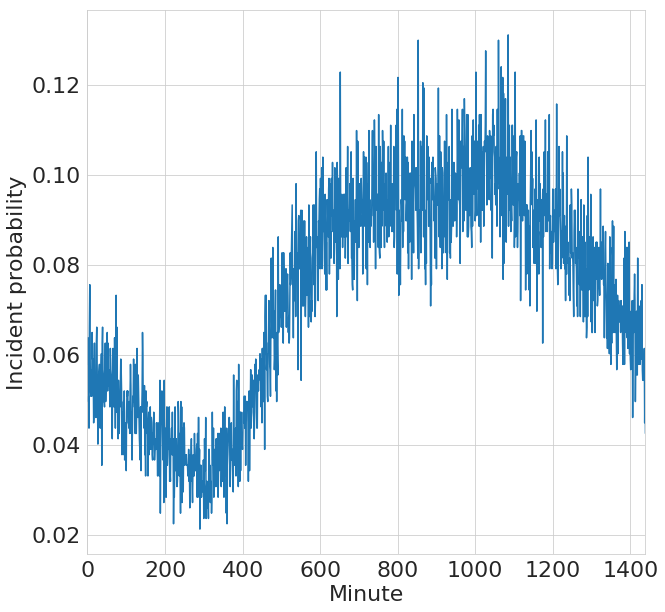

In [39]:
def interval_agg(x,num_days):
    d = {
        'spike_prob': len(np.unique(x['date']))/num_days
    }
    return pd.Series(d,index=d.keys())


interval_df = df.groupby(['minute']).apply(lambda x: interval_agg(x,num_days)).reset_index()
#need to map the minutes to a continous variable for plotting
interval_df['cont_min'] = interval_df.apply(lambda x: float(x['minute'][:2])*60 + 
                                   float(x['minute'][3:]), axis=1)

#convert to datetime objects for plotting
interval_df['datetime'] = interval_df.apply(lambda x: datetime(2000,1,1,int(x['minute'][:2]),int(x['minute'][3:])),axis=1)

# formatter = DateFormatter('%H:%M')
plt.plot(interval_df['cont_min'], interval_df['spike_prob'])
# plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.xlim([0,1439])
plt.xlabel('Minute')

plt.ylabel('Incident probability')

# DFT to identify dominant frequencies

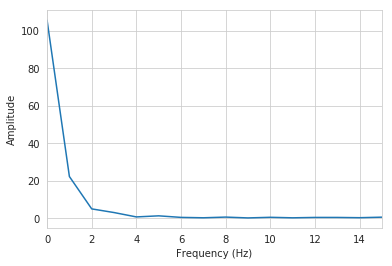

In [5]:
plt.plot(np.abs(np.fft.fft(interval_df['spike_prob'])[0:20]))
plt.xlim([0,15])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.savefig('dft')

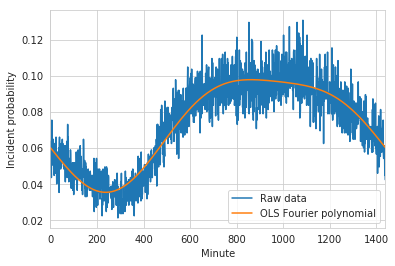

In [6]:
#Constructing fourier basis for function and then basic linear regression

max_order = 3
x = np.array(range(1440))
basis_matrix = np.ones([len(interval_df),2*max_order+1]) #The two is because there are cos and sin terms for each order
wo = 2*np.pi/1440


for n in range(1,max_order):
    basis_matrix[:,2*n] = np.cos(n*wo*x)
    basis_matrix[:,2*n+1] = np.sin(n*wo*x)

mod = sm.OLS( interval_df['spike_prob'], basis_matrix)
res = mod.fit()
#unpacking the coefficients
coef = np.array(res.params)


#then make sum of fourier polynomials
pred = basis_matrix @ coef

    
plt.plot(x, interval_df['spike_prob'])
plt.plot(x,pred)
plt.xlabel('Minute')
plt.ylabel('Incident probability')
plt.xlim([0,1439])
plt.legend(['Raw data', 'OLS Fourier polynomial'])

    

# Gibbs sampling to get uncertainty of fourier polynomial fit

In [7]:
num_iter = 1000
max_order = 3 #order of Fourier polynomial
num_terms = 2*max_order+1 #extra term for intercept

y = np.array(expanded_df['spike'])
x = np.array(expanded_df['cont_minute'])

#Make dummy matrix for categorial daily attributes 
dummies = pd.get_dummies(expanded_df['day_of_week'])
num_features = len(dummies.columns) #the number of categorical predictors
feature_list = dummies.columns
#Need to drop first feature 
dummies = pd.get_dummies(expanded_df['day_of_week'],drop_first=True)


basis_matrix = np.ones([len(x),num_terms,num_features]) #The two is because there are cos and sin terms for each order
wo = 2*np.pi/1440


#Filling in base case effects
for n in range(1,max_order+1):
    basis_matrix[:,2*n-1,0] = np.cos(n*wo*x)
    basis_matrix[:,2*n,0] = np.sin(n*wo*x)
    
#Filling in effects for other cases    
for i,day in enumerate(dummies.columns):
    basis_matrix[:,:,i+1] = basis_matrix[:,:,0]*np.reshape(np.tile(np.array(dummies[day]),num_terms), (len(x),num_terms),order='F')
    
basis_matrix = np.reshape(basis_matrix,(len(x), num_terms*num_features ),order='F')


#Prior of beta is mean zero with a diagnonal matrix of ones as the covariance
#Note that the 1 for the variance is relatively uninformed because it is within a probit function
mu = np.zeros(num_terms*num_features)
prec_mat = np.diag(np.ones(num_terms*num_features))

#initializing beta
beta_trace = np.zeros([num_iter,num_terms*num_features])

#initialize z, the latent variable
z = np.zeros(len(x))



for i in tqdm_notebook(range(num_iter)):
    V = np.linalg.inv(prec_mat + basis_matrix.T@basis_matrix)
    m = V@(prec_mat @ mu + basis_matrix.T @ z)
    
    #update beta
    beta_trace[i,:] = np.random.multivariate_normal(m,V)

    mean_z = basis_matrix@beta_trace[i,:]

    #setting up bounds for truncated normal draws on z
    lower = np.ones(len(z))*(y-1)*10**10
    upper = np.ones(len(z))*y*10**10

    a = lower - mean_z
    b = upper - mean_z
    
    #Depending on whether a call happened during that minute, choose a truncated normal draw for z
    z = truncnorm(a,b,loc=mean_z).rvs()


# Plotting traces to ensure mixing

Text(0, 0.5, '$\\beta_i$')

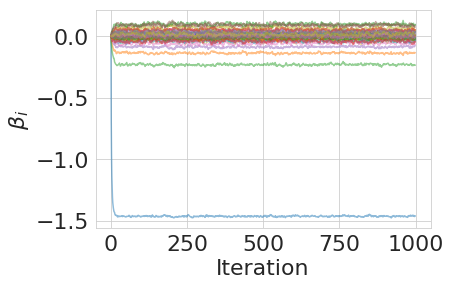

In [8]:
plt.rcParams.update({'font.size': 22})
plt.plot(beta_trace, alpha=.5)
plt.xlabel('Iteration')
plt.ylabel(r"$\beta_i$")


# Randomly sample traces to see how different the fits are

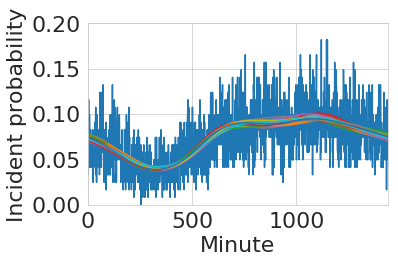

In [9]:
day = 'Saturday'


#Parameters for plotting traces
burn = 20
n_curves = 10
traces = np.random.randint(burn,len(beta_trace),50)
minute_array = np.array(range(1440))

#Need to create a fill dataframe with probability zero to fill in missing times from interval_df
d = {
    'cont_min': np.arange(0,1440),
    'spike_prob': np.zeros(1440),
    'minute': [str(int(i/60)).zfill(2) + ":" + str(int(i%60)).zfill(2) for i in np.arange(1440)]
}

fill_df = pd.DataFrame(d)


#First plotting the spike data for each day of the week
day_df = df[df['description.day_of_week'] == day].copy()

#Determine total number of days in set
num_days = len(np.unique(day_df['date']))

interval_df = day_df.groupby(['minute']).apply(lambda x: interval_agg(x,num_days)).reset_index()
#need to map the minutes to a continous variable for plotting
interval_df['cont_min'] = interval_df.apply(lambda x: float(x['minute'][:2])*60 + 
                                   float(x['minute'][3:]), axis=1)

#Fill in any missing times
merged = pd.merge(interval_df,fill_df, on=['minute','cont_min'],  how='outer',indicator=True)
merged.loc[merged['_merge']=='right_only','spike_prob_x'] = 0
merged.rename(columns={'spike_prob_x':'spike_prob'},inplace=True)
interval_df = merged.sort_values('minute').reset_index()

#This let's us convert the trace results back into functions defined over the whole day
minute_matrix = np.zeros([1440,num_terms*num_features])
minute_matrix[:,0] = 1.0 #The intercept term
for n in range(1,max_order+1):
    minute_matrix[:,2*n-1] = np.cos(n*wo*minute_array)
    minute_matrix[:,2*n] = np.sin(n*wo*minute_array)
    
#Find where in the feature list it is the right day
idx = np.where(feature_list==day)[0][0]
minute_matrix[:,num_terms*idx:num_terms*idx+num_terms] = minute_matrix[:,0:num_terms]

beta_mean = [np.mean(beta_trace[burn:,i]) for i in range(num_features*num_terms)]

plt.plot(minute_array,interval_df['spike_prob'])
for i in traces:
    plt.plot(minute_array,norm.cdf(minute_matrix@beta_trace[i,:]))

plt.xlabel('Minute')
plt.ylabel('Incident probability')
plt.xlim([0,1439])
plt.ylim([0,0.2])
plt.tight_layout()




# Distribution of the rate parameter

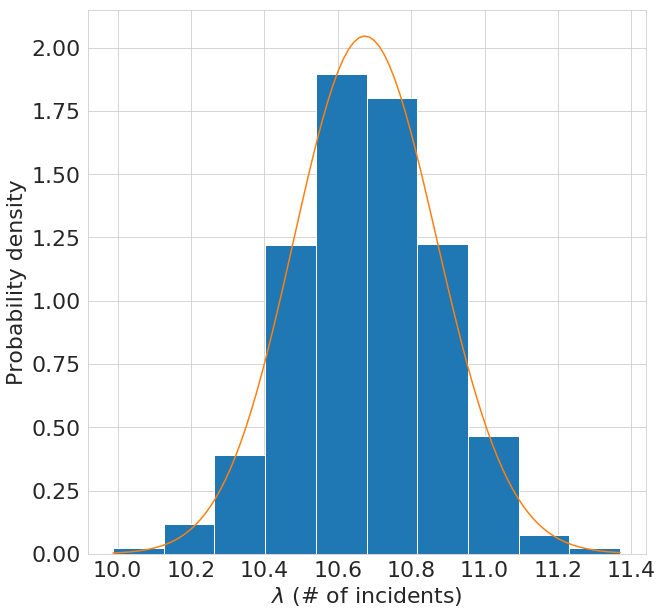

In [88]:
#Simulating call volumes based on regression fits
from scipy.stats import gamma, nbinom
plt.rcParams['figure.figsize'] = [10, 10]

day = 'Friday'
start = 20
end = 22

nu = np.zeros(1440) #vector that picks which intervals are in the rate
nu[start*60:end*60] = 1.0

minute_matrix = np.zeros([1440,num_terms*num_features])
minute_matrix[:,0] = 1.0 #The intercept term
for n in range(1,max_order+1):
    minute_matrix[:,2*n-1] = np.cos(n*wo*minute_array)
    minute_matrix[:,2*n] = np.sin(n*wo*minute_array)
    
#Find where in the feature list it is the right day
idx = np.where(feature_list==day)[0][0]
minute_matrix[:,num_terms*idx:num_terms*idx+num_terms] = minute_matrix[:,0:num_terms]


rates = norm.cdf(beta_trace[burn:,:]@minute_matrix.T)@nu

#Determine fitted gamma distribution by moment matching
mean = np.mean(rates)
var = np.var(rates)

scale = var/mean
a = mean**2/var
x = np.linspace(np.min(rates),np.max(rates),100)


#Plotting
plt.hist(rates,density=True)
plt.plot(x,gamma.pdf(x,a,scale=scale))
plt.xlabel(r'$\lambda$ (# of incidents)')
plt.ylabel('Probability density')
plt.savefig('ratedist')

# Finally the distribution of call volumes for the specified interval
Be careful with the bin ranges. It's currently hardcoded to 100, but that can cause issues if you have a bigger call volume


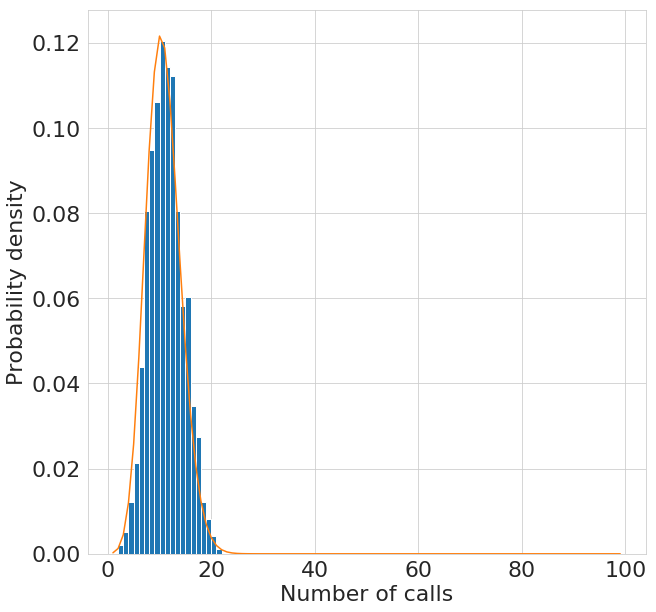

In [91]:
#Call volume predictions
p = scale/(1-scale)
n = np.array(range(1,100))
plt.hist(np.random.poisson(rates),density=True,bins=np.array(range(1,100)))
plt.plot(n,nbinom.pmf(n,int(a),1-p))

#Compare to random draws of posterior and poisson
plt.xlabel('Number of calls')
plt.ylabel('Probability density')
plt.savefig('callvolume')